# Sentence Graph Modification to enhance the information content

In [1]:
sample = 'RhoU is an atypical Rho family member with high homology to CDC42 but containing unique N- and C-terminal extensions. The mechanisms regulating RhoU activation, as well as its downstream effectors, are not fully characterized. We show that after epidermal growth factor (EGF) stimulation RhoU colocalizes with EGF receptor (EGFR) on endosomes, which requires both its N- and C-terminal extension sequences. Moreover, RhoU physically associates with activated EGFR in a GRB2-dependent manner through specific proline-rich motifs within its N-terminus. Mutation of these proline-rich sequences or suppression of GRB2 by RNA interference abrogates the interaction of RhoU with activated EGFR, as well as EGF-stimulated RhoU GTP binding. In addition, RhoU is involved in EGFR-mediated signaling, leading to AP1 transcriptional activity and cell migration in pancreatic cancer cells, events that require its interaction with the Grb2-EGFR complex. Taken together, the data suggest a unique regulatory mechanism by which RhoU interaction with SH3 adaptor proteins might serve to integrate growth factor receptor signaling with RhoU activation.'


In [2]:
def cleanTxt(sample):
    clean = []
    sentences = sample.split('.')
    for s in sentences:
        if len(s)!=0:
            clean.append(s.strip()+'.')
    return clean

In [3]:
c = cleanTxt(sample)
c

['RhoU is an atypical Rho family member with high homology to CDC42 but containing unique N- and C-terminal extensions.',
 'The mechanisms regulating RhoU activation, as well as its downstream effectors, are not fully characterized.',
 'We show that after epidermal growth factor (EGF) stimulation RhoU colocalizes with EGF receptor (EGFR) on endosomes, which requires both its N- and C-terminal extension sequences.',
 'Moreover, RhoU physically associates with activated EGFR in a GRB2-dependent manner through specific proline-rich motifs within its N-terminus.',
 'Mutation of these proline-rich sequences or suppression of GRB2 by RNA interference abrogates the interaction of RhoU with activated EGFR, as well as EGF-stimulated RhoU GTP binding.',
 'In addition, RhoU is involved in EGFR-mediated signaling, leading to AP1 transcriptional activity and cell migration in pancreatic cancer cells, events that require its interaction with the Grb2-EGFR complex.',
 'Taken together, the data sugges

In [4]:
import BMTextTokenizer as bmt
import matplotlib.pyplot as plt
import stanza
import time
%matplotlib inline

2022-02-22 11:53:35 INFO: Loading these models for language: en (English):
| Processor | Package    |
--------------------------
| tokenize  | craft      |
| pos       | craft      |
| lemma     | craft      |
| depparse  | craft      |
| ner       | bionlp13cg |

2022-02-22 11:53:35 INFO: Use device: cpu
2022-02-22 11:53:35 INFO: Loading: tokenize
2022-02-22 11:53:35 INFO: Loading: pos
2022-02-22 11:53:35 INFO: Loading: lemma
2022-02-22 11:53:35 INFO: Loading: depparse
2022-02-22 11:53:35 INFO: Loading: ner
2022-02-22 11:53:35 INFO: Done loading processors!
2022-02-22 11:53:35 INFO: Loading these models for language: en (English):
| Processor | Package    |
--------------------------
| tokenize  | craft      |
| pos       | craft      |
| lemma     | craft      |
| depparse  | craft      |
| ner       | bionlp13cg |

2022-02-22 11:53:35 INFO: Use device: cpu
2022-02-22 11:53:35 INFO: Loading: tokenize
2022-02-22 11:53:35 INFO: Loading: pos
2022-02-22 11:53:36 INFO: Loading: lemma
2022

In [5]:
pretokenized_nlp = stanza.Pipeline(lang='en', package='craft', processors={'ner': 'BioNLP13CG'}, tokenize_pretokenized=True)


2022-02-22 11:53:51 INFO: Loading these models for language: en (English):
| Processor | Package    |
--------------------------
| tokenize  | craft      |
| pos       | craft      |
| lemma     | craft      |
| depparse  | craft      |
| ner       | bionlp13cg |

2022-02-22 11:53:51 INFO: Use device: cpu
2022-02-22 11:53:51 INFO: Loading: tokenize
2022-02-22 11:53:51 INFO: Loading: pos
2022-02-22 11:53:52 INFO: Loading: lemma
2022-02-22 11:53:52 INFO: Loading: depparse
2022-02-22 11:53:52 INFO: Loading: ner
2022-02-22 11:53:52 INFO: Done loading processors!


RhoU is an atypical Rho family member with high homology to CDC42 but containing unique N- and C-terminal extensions.
********************** Convergence ***************************
Prev size: 21 Vs. Next size 16
Prev size: 16 Vs. Next size 14
Prev size: 14 Vs. Next size 12
Prev size: 12 Vs. Next size 12
************************ ReTokenized *************************
id: 1	word: RhoU                	deprel: nsubj   	upos: PROPN 	head: atypical Rho family member
id: 2	word: is                  	deprel: cop     	upos: AUX   	head: atypical Rho family member
id: 3	word: an                  	deprel: det     	upos: DET   	head: atypical Rho family member
id: 4	word: atypical Rho family member	deprel: root    	upos: NOUN  	head: root
id: 5	word: with                	deprel: case    	upos: ADP   	head: high homology       
id: 6	word: high homology       	deprel: nmod    	upos: NOUN  	head: atypical Rho family member
id: 7	word: to                  	deprel: case    	upos: ADP   	head: CDC42    

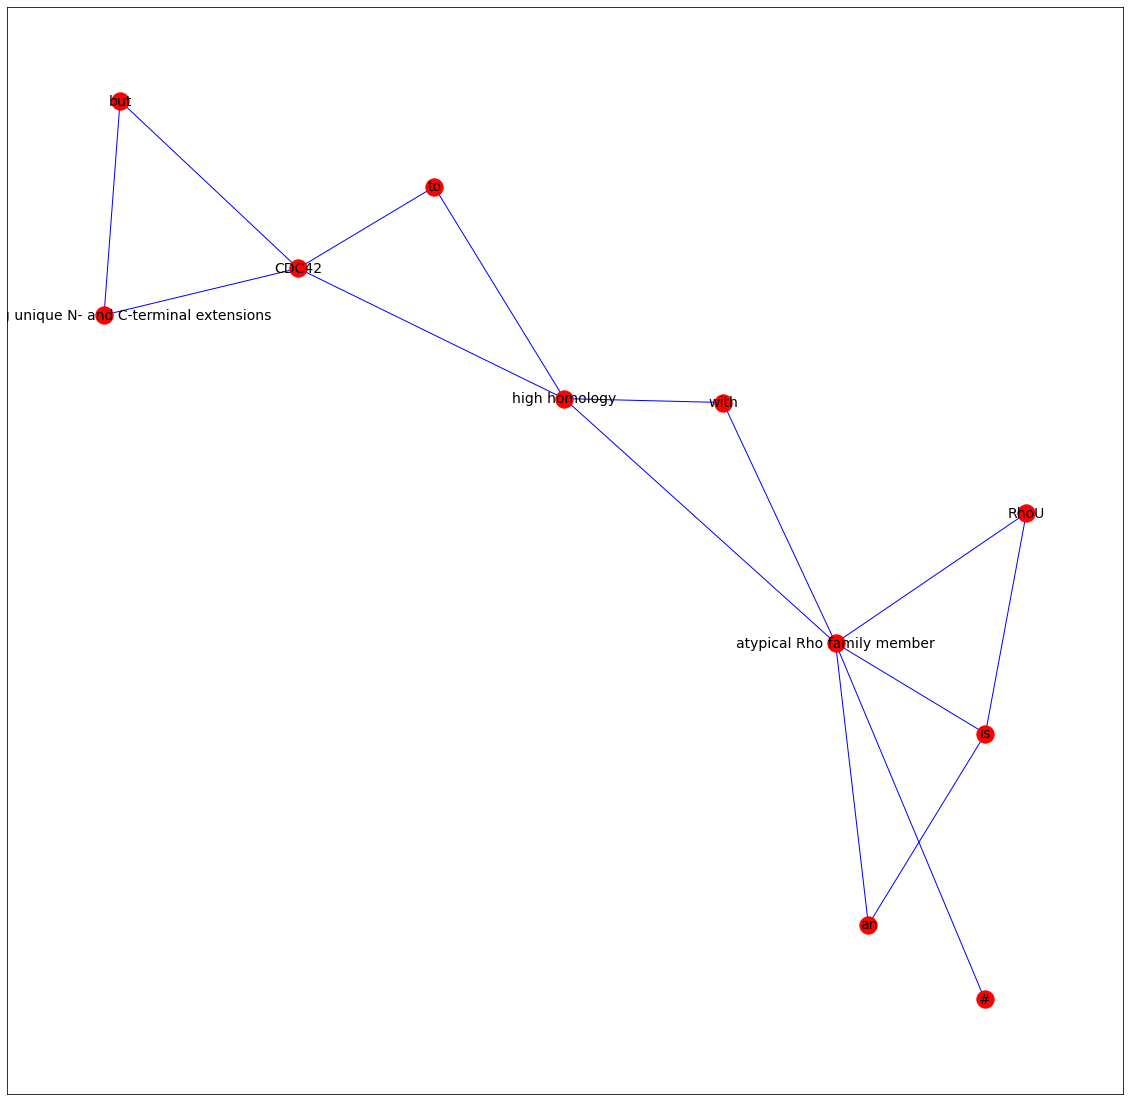

In [6]:
bmt.sandboxGP01(c[0])

### Modification made to the Graph - weight assignment
The purpose is to draw entities of interest closer to what act on them, what describes them, how they are related.
1. Consider the edge weight is proportional to the weight of two connected nodes (i.e. a pseudo-gravitational model)

2. Consider higher weight for ents extracted in the process in order to differentiate it freom other phrases/words.

In [16]:
doc = bmt.dynamicTokenizer(nlp=pretokenized_nlp, text=c[0])
tokens = [word.text for sent in doc.sentences for word in sent.words]
G = bmt.createTokenGraphwithContractionGP01(doc) # undirected graph

Prev size: 21 Vs. Next size 16
Prev size: 16 Vs. Next size 14
Prev size: 14 Vs. Next size 12
Prev size: 12 Vs. Next size 12


In [17]:
bmt.printEnt(doc)

entity: RhoU                          	type: GENE_OR_GENE_PRODUCT
entity: CDC42                         	type: GENE_OR_GENE_PRODUCT


In [27]:
# Helper functions to weight assignment
import math
def updateNodeWt(G):
    """
    Input: a networkx Graph
    Output: a networkx Graph with updated node weight
    """
    pos = nx.get_node_attributes(G, 'pos')
    for node, pos in pos.items():
        if pos=='VERB' or node=='not':
            G.nodes[node]['weight']=math.exp(2) # ~ 7.38905609893
        elif pos=='NOUN':
            G.nodes[node]['weight']=math.exp(1) # ~ 2.71828182846
        else:
            G.nodes[node]['weight']=math.exp(0) # = 1
    return G

def updateEntWt(G, doc):
    """
    Input: a networkx Graph
    Output: a networkx Graph with updated entity weight, replace the assignment under UpdateNodeWt() function
    """    
    ents = [ent.text for sent in doc.sentences for ent in sent.ents if ent.type=='GENE_OR_GENE_PRODUCT']
    print (ents)
    for node in G.nodes():
        if node in ents:
            G.nodes[node]['weight']=math.exp(3) # ~ 20.0855369232
    return G

def updateEdgeWt(G):
    """
    Input: a networkx Graph
    Output: a networkx Graph with updated edge weight
    """    
    edges = nx.get_edge_attributes(G, 'weight')
    nodes = nx.get_node_attributes(G, 'weight')
    for edge, weight in edges.items():
        G.edges[edge]['weight'] = math.sqrt(nodes[edge[0]]*nodes[edge[1]])
    return G

In [19]:
import networkx as nx
G = bmt.updateNodeWt(G)
G = bmt.updateEntWt(G, doc)
weight = nx.get_node_attributes(G,'weight')
weight

['RhoU', 'CDC42']


{'RhoU': 20.085536923187668,
 'is': 1.0,
 'an': 1.0,
 'atypical Rho family member': 2.718281828459045,
 'with': 1.0,
 'high homology': 2.718281828459045,
 'to': 1.0,
 'CDC42': 20.085536923187668,
 'but': 1.0,
 'containing unique N- and C-terminal extensions': 2.718281828459045,
 '#': 1.0}

In [20]:
edge_wt = nx.get_edge_attributes(G, 'weight')
edge_wt

{('RhoU', 'is'): 1,
 ('RhoU', 'atypical Rho family member'): 1,
 ('is', 'an'): 1,
 ('is', 'atypical Rho family member'): 1,
 ('an', 'atypical Rho family member'): 1,
 ('atypical Rho family member', 'with'): 1,
 ('atypical Rho family member', '#'): 1,
 ('atypical Rho family member', 'high homology'): 1,
 ('with', 'high homology'): 1,
 ('high homology', 'to'): 1,
 ('high homology', 'CDC42'): 1,
 ('to', 'CDC42'): 1,
 ('CDC42', 'but'): 1,
 ('CDC42', 'containing unique N- and C-terminal extensions'): 1,
 ('but', 'containing unique N- and C-terminal extensions'): 1}

In [21]:
G = bmt.updateEdgeWt(G)
edge_wt = nx.get_edge_attributes(G, 'weight')
edge_wt

{('RhoU', 'is'): 4.4816890703380645,
 ('RhoU', 'atypical Rho family member'): 7.38905609893065,
 ('is', 'an'): 1.0,
 ('is', 'atypical Rho family member'): 1.6487212707001282,
 ('an', 'atypical Rho family member'): 1.6487212707001282,
 ('atypical Rho family member', 'with'): 1.6487212707001282,
 ('atypical Rho family member', '#'): 1.6487212707001282,
 ('atypical Rho family member', 'high homology'): 2.718281828459045,
 ('with', 'high homology'): 1.6487212707001282,
 ('high homology', 'to'): 1.6487212707001282,
 ('high homology', 'CDC42'): 7.38905609893065,
 ('to', 'CDC42'): 4.4816890703380645,
 ('CDC42', 'but'): 4.4816890703380645,
 ('CDC42', 'containing unique N- and C-terminal extensions'): 7.38905609893065,
 ('but', 'containing unique N- and C-terminal extensions'): 1.6487212707001282}

In [26]:
paths = bmt.generateSimplePath(G, ['RhoU', 'CDC42'])
count=0
length=0
for p in paths:
    print (p, 'has length %i' %len(p))
    count += 1
    length += len(p)
print ('Average Length: %0.2f' %float(int(length)/int(count)))

['RhoU', 'is', 'an', 'atypical Rho family member', 'with', 'high homology', 'to', 'CDC42'] has length 8
['RhoU', 'is', 'an', 'atypical Rho family member', 'with', 'high homology', 'CDC42'] has length 7
['RhoU', 'is', 'an', 'atypical Rho family member', 'high homology', 'to', 'CDC42'] has length 7
['RhoU', 'is', 'an', 'atypical Rho family member', 'high homology', 'CDC42'] has length 6
['RhoU', 'is', 'atypical Rho family member', 'with', 'high homology', 'to', 'CDC42'] has length 7
['RhoU', 'is', 'atypical Rho family member', 'with', 'high homology', 'CDC42'] has length 6
['RhoU', 'is', 'atypical Rho family member', 'high homology', 'to', 'CDC42'] has length 6
['RhoU', 'is', 'atypical Rho family member', 'high homology', 'CDC42'] has length 5
['RhoU', 'atypical Rho family member', 'with', 'high homology', 'to', 'CDC42'] has length 6
['RhoU', 'atypical Rho family member', 'with', 'high homology', 'CDC42'] has length 5
['RhoU', 'atypical Rho family member', 'high homology', 'to', 'CDC42']

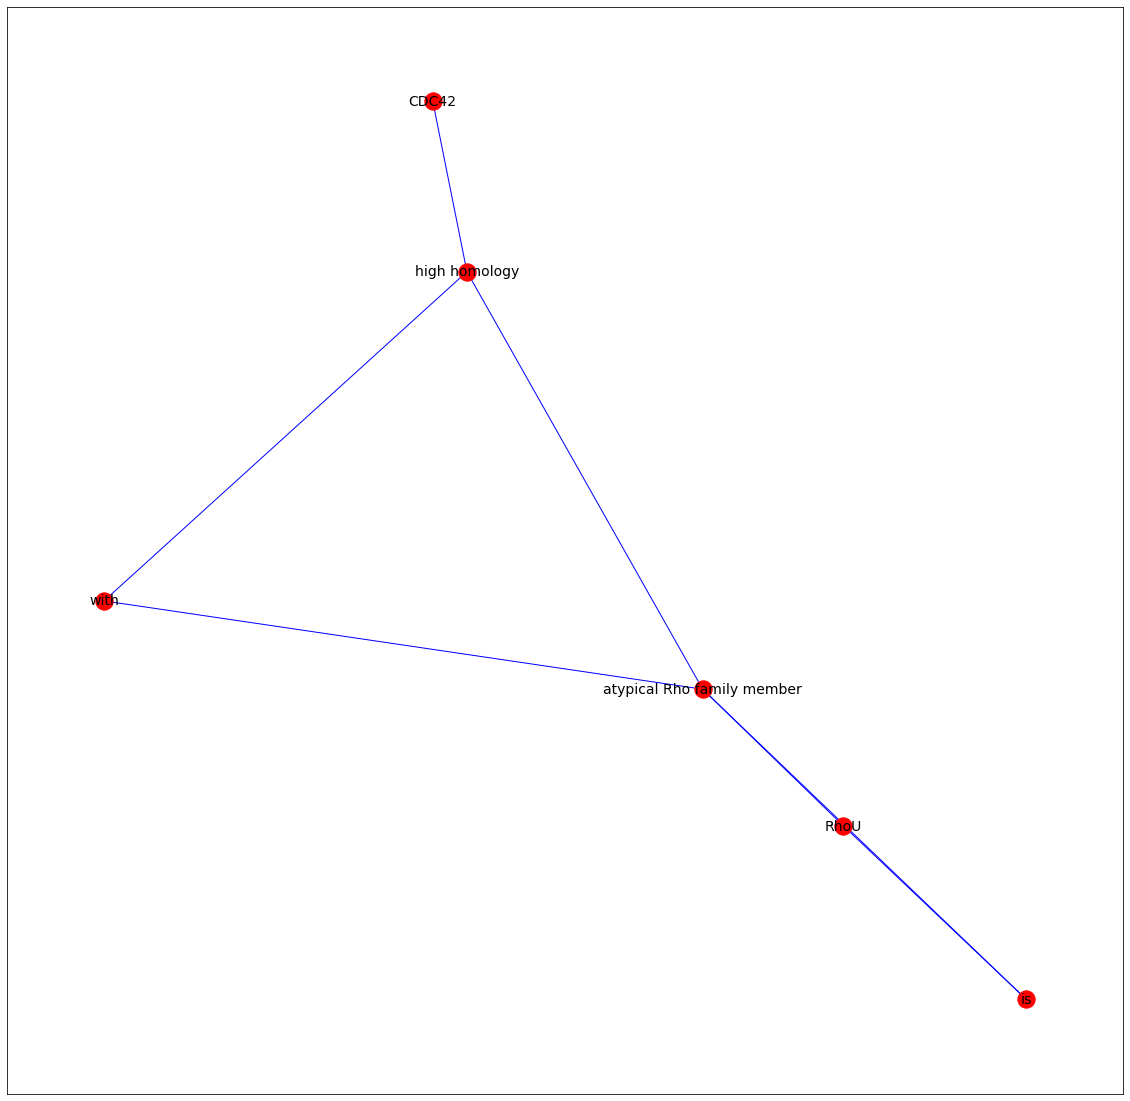

In [28]:
H = G.subgraph(['RhoU', 'is', 'atypical Rho family member', 'with', 'high homology', 'CDC42']) # Example
bmt.plot_network(H)